# **Coursework 2: Local Feature Detection and Matching for Object Recognition**

## **1. Preparation**

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import sobel
from scipy.ndimage import convolve
from scipy.ndimage import gaussian_filter
from scipy.ndimage import maximum_filter
from scipy.spatial.distance import cdist

In [20]:
def generate_gaussian_kernel(size, sigma):                          # Generate Gaussian kernel with specified size and sigma;
    kernel_1d = cv2.getGaussianKernel(size, sigma)

    return np.outer(kernel_1d, kernel_1d.T)

def get_color(file_path):                                           # Read an (colorful) image file, return its RGB representation (for visualisation);
    img = cv2.imread(file_path)

    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def get_grayscale(file_path):                                       # Read an image file, return its unblurred grayscale representation;
    img = cv2.imread(file_path)

    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def get_blurred_grayscale(file_path: str, size=21, sigma=5):        # Read an image file, return its grayscale (blurred by a specified Gaussian kernel) of 'float64';
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype(np.float64)

    return convolve(img, generate_gaussian_kernel(size, sigma), mode='mirror')

def handle_outsiders(img, method='clip'):                           # Handle intensity values not in [0, 255] for visualisation, assuming input np.array of 'float64';
    img = img.astype(np.int64)

    if method == 'clip':
        img = np.clip(img, 0, 255)
    elif method == 'rescale':
        img = 255 * (img - img.min()) / (img.max() - img.min())
    else:
        raise ValueError("Invalid method")

    img = img.astype(np.uint8)

    return img

## **2. Feature detection**

**2.1 Import, monochromatise and blur the reference image**

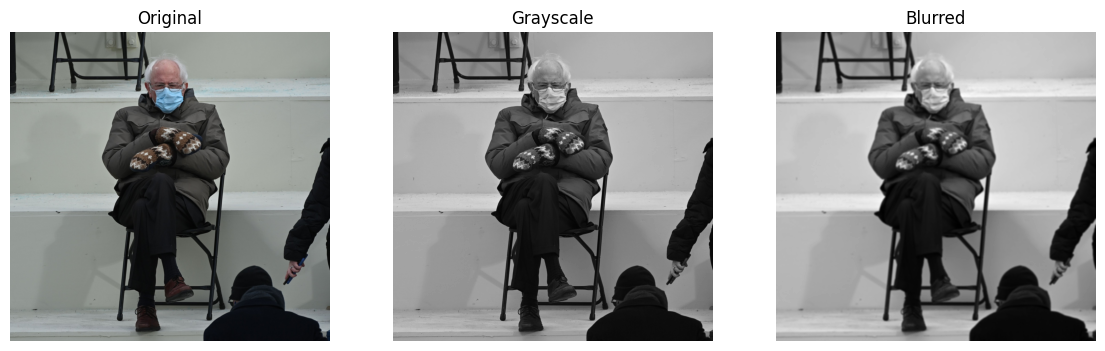

In [21]:
img_ori = get_color('bernieSanders.jpg')
img_gray = get_grayscale('bernieSanders.jpg')
I = get_blurred_grayscale('bernieSanders.jpg')

plt.figure(figsize=(14, 12))
plt.subplot(1, 3, 1), plt.imshow(img_ori), plt.axis('off'), plt.title('Original')
plt.subplot(1, 3, 2), plt.imshow(img_gray, cmap='gray'), plt.axis('off'), plt.title('Grayscale')
plt.subplot(1, 3, 3), plt.imshow(handle_outsiders(I.copy(), method='clip'), cmap='gray'), plt.axis('off'), plt.title('Blurred')
plt.show()

\\
**2.2 Calculate Harris corner responses and orientations**



*   Use the 3x3 **Sobel operator** with *reflect* padding to compute the x, y derivatives, $I_x$ and $I_y$.
*   Using a 5x5 **Gaussian** filter with $σ=0.5$ (as specified) as the window function, the Harris matrix $M$ (for a pixel) is represented as:
$$M = \sum \; g(σ=0.5) * \begin{pmatrix} I_x^2 & I_xI_y \\ I_xI_y & I_y^2 \end{pmatrix}$$
Thus, compute $I_x^2$, $I_y^2$, $I_xI_y$ accordingly.
*   For each pixel, compute its:
    *   **corner response** using the equivalent formula, ($α=0.05$ as specified):

        \begin{align}
        R &= det(M) - 0.05[trace(M)]^2 \\
          &= g(I_x^2)g(I_y^2) - g(I_xI_y)^2 - 0.05[g(I_x^2) + g(I_y^2)]^2
        \end{align}

    *   **orientation** in degrees $[0^{∘}, 360^{∘})$:

        $$θ = tan^{-1}(\frac{I_y}{I_x})$$
        
    And return as two matrices.





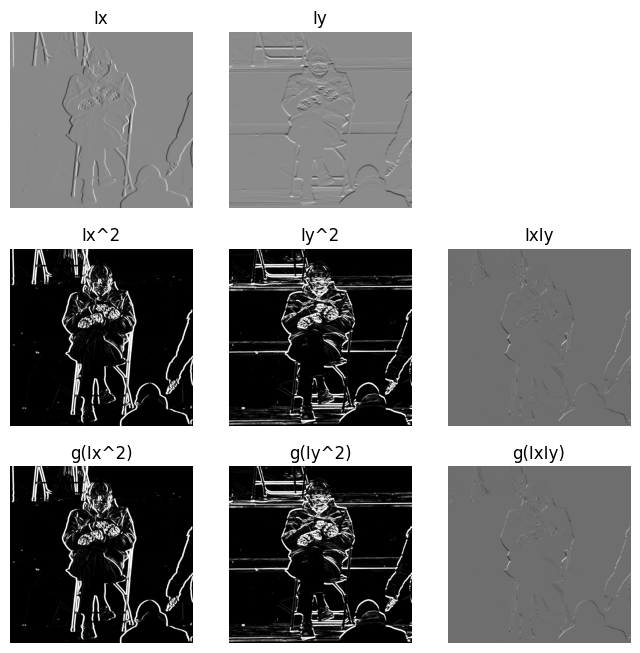

In [22]:
def get_responses_angles(img):
    I_x = sobel(img, axis=1, mode='mirror')
    I_y = sobel(img, axis=0, mode='mirror')
    I_x2, I_y2, I_xy = I_x ** 2, I_y ** 2, I_x * I_y

    g = generate_gaussian_kernel(5, 0.5)
    Rs = (
        convolve(I_x2, g, mode='mirror') * convolve(I_y2, g, mode='mirror') -
        convolve(I_xy, g, mode='mirror') ** 2 -
        0.05 * (convolve(I_x2, g, mode='mirror') + convolve(I_y2, g, mode='mirror')) ** 2
    )

    orientations = np.arctan2(I_y, I_x) * 180 / np.pi
    orientations[orientations < 0] += 360

    return I_x, I_y, I_x2, I_y2, I_xy, Rs, orientations

g = generate_gaussian_kernel(5, 0.5)
I_x, I_y, I_x2, I_y2, I_xy, Rs, orientations = get_responses_angles(I)

plt.figure(figsize=(8, 8))
plt.subplot(3, 3, 1), plt.imshow(handle_outsiders(I_x.copy(), method='rescale'), cmap='gray'), plt.axis('off'), plt.title('Ix')
plt.subplot(3, 3, 2), plt.imshow(handle_outsiders(I_y.copy(), method='rescale'), cmap='gray'), plt.axis('off'), plt.title('Iy')
plt.subplot(3, 3, 4), plt.imshow(handle_outsiders(I_x2.copy(), method='clip'), cmap='gray'), plt.axis('off'), plt.title('Ix^2')
plt.subplot(3, 3, 5), plt.imshow(handle_outsiders(I_y2.copy(), method='clip'), cmap='gray'), plt.axis('off'), plt.title('Iy^2')
plt.subplot(3, 3, 6), plt.imshow(handle_outsiders(I_xy.copy(), method='rescale'), cmap='gray'), plt.axis('off'), plt.title('IxIy')
plt.subplot(3, 3, 7), plt.imshow(handle_outsiders(convolve(I_x2, g, mode='mirror').copy(), method='clip'), cmap='gray'), plt.axis('off'), plt.title('g(Ix^2)')
plt.subplot(3, 3, 8), plt.imshow(handle_outsiders(convolve(I_y2, g, mode='mirror').copy(), method='clip'), cmap='gray'), plt.axis('off'), plt.title('g(Iy^2)')
plt.subplot(3, 3, 9), plt.imshow(handle_outsiders(convolve(I_xy, g, mode='mirror').copy(), method='rescale'), cmap='gray'), plt.axis('off'), plt.title('g(IxIy)')
plt.show()


\\
**2.3 Select interest points**

*   Perform thresholding on pixels' corner response values, and plot graph of the changing of number of interest points by varying threshold value.

    **Regarding threshold setting**: since what will be compared later are *three sets of descriptors* that are created using keypoints found by **my Harris detector**, **ORB.detect(Harris)** and **ORB.detect(FAST)** respectively, choose a threshold value such that the number of keypoints (after that threshold value and a 7x7 local maximisation being applied) is close to the number of keypoints found by either ORB.detect(Harris) or ORB.detect(FAST). This gives a soft-coded threshold setting that can be adjusted for different images.

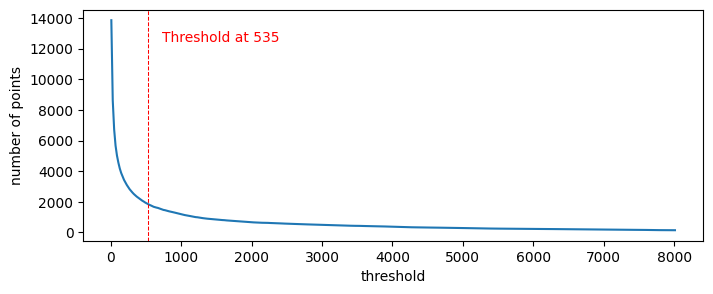

In [23]:
def choose_threshold(img):
    Rs = get_responses_angles(img)[5]
    I = handle_outsiders(img.copy(), method='clip')
    num_orb_points = len(cv2.ORB_create().detect(I, None))

    t = 0
    while True:
        n = ((Rs >= t) & (Rs == maximum_filter(Rs, size=7, mode='mirror'))).sum()

        if abs(n - num_orb_points) <= 10:
            return t

        t += 5

t = choose_threshold(I)

x = np.arange(10, np.max(Rs) / 5, 20)
y = np.array([(Rs >= t).sum() for t in x])

plt.figure(figsize=(8, 3))
plt.plot(x, y), plt.xlabel('threshold'), plt.ylabel('number of points')
plt.axvline(x=t, color='r', linestyle='--', linewidth=0.75), plt.text(t + 200, max(y) * 0.9, f'Threshold at {t}', color='red')
plt.show()

*   After thresholding, select the strongest keypoints which are local maxima in a 7x7 neighbourhood.



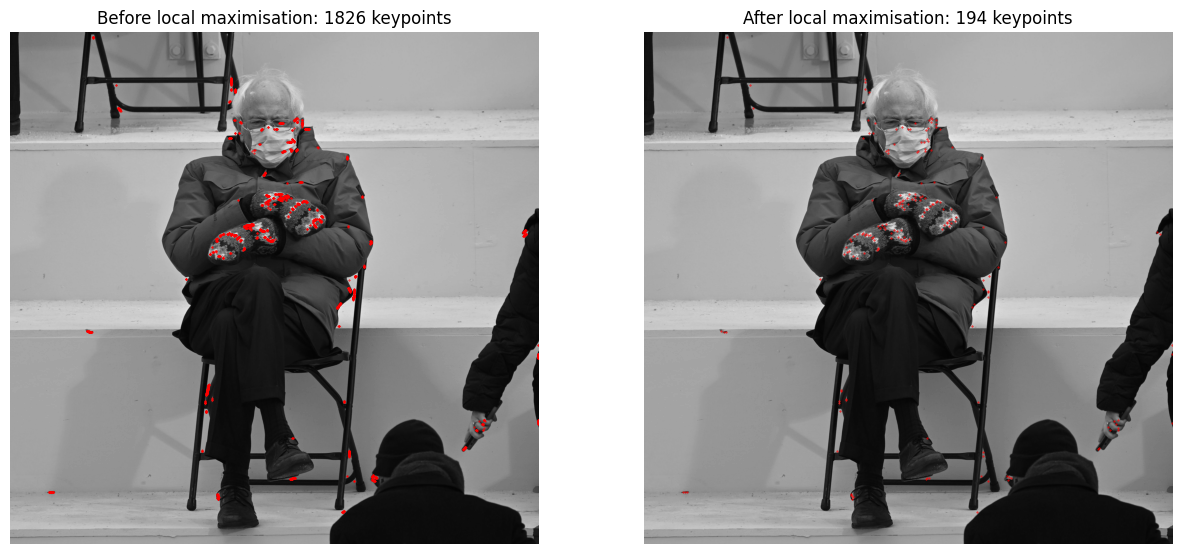

In [24]:
bf_coordinates = np.where(Rs >= t)
af_coordinates = np.where((Rs >= t) & (Rs == maximum_filter(Rs, size=7, mode='mirror')))

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1), plt.imshow(img_gray, cmap='gray'), plt.axis('off')
for y, x in zip(bf_coordinates[0], bf_coordinates[1]):
    plt.plot(x, y, 'ro', markersize=0.4)
plt.title(f'Before local maximisation: {len(bf_coordinates[0])} keypoints')
plt.subplot(1, 2, 2), plt.imshow(img_gray, cmap='gray'), plt.axis('off')
for y, x in zip(af_coordinates[0], af_coordinates[1]):
    plt.plot(x, y, 'ro', markersize=0.4)
plt.title(f'After local maximisation: {len(af_coordinates[0])} keypoints')
plt.show()

*   Finally, using the locations and orientations (of those strong keypoints) calculated before, create a list of **cv2.KeyPoint** objects as input for **ORB.compute()** function to generate descriptor for each point.

    Also, create the main function ***HarrisPointsDetector*** that combines all the above procedurals together.

In [25]:
size = 11

def HarrisPointsDetector(image, threshold, size):
    _, _, _, _, _, Rs, orientations = get_responses_angles(image)

    np_coordinates = np.where((Rs >= threshold) & (Rs == maximum_filter(Rs, size=7, mode='mirror')))

    num = len(np_coordinates[0])
    kps = []

    for i in range(num):
        row = np_coordinates[0][i]
        col = np_coordinates[1][i]

        kp = cv2.KeyPoint(x=float(col), y=float(row), angle=orientations[row, col], size=size)
        kps.append(kp)

    return kps

\\

\\

\\

\\
## **3. Feature description**

Create descriptor matrices using **ORE.compute** for keypoints found by *my Harris* detector, *ORE.detect(Harris)* and *ORE.detect(FAST)*, respectively.

\\

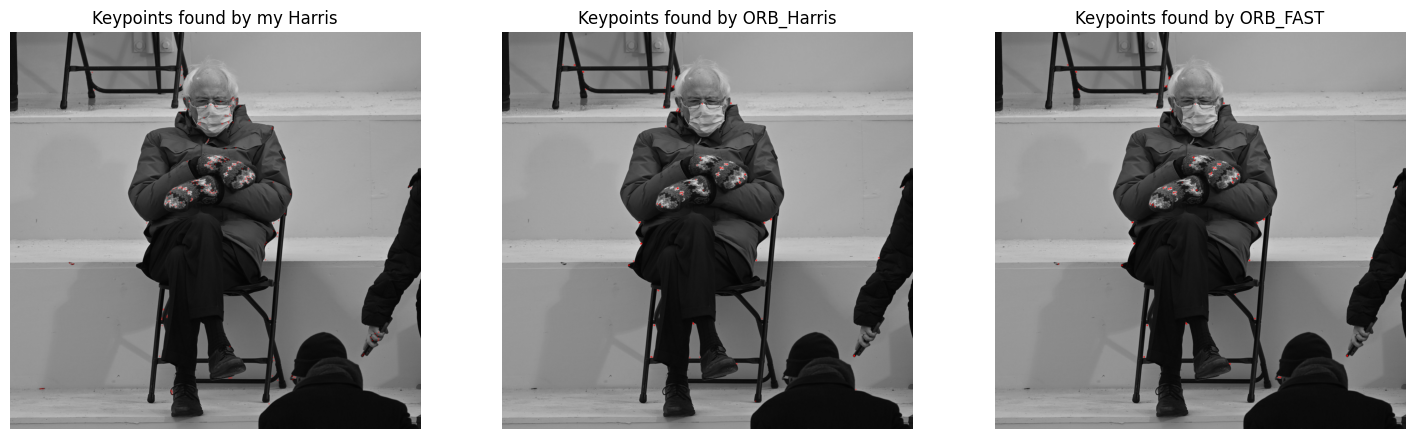

In [26]:
def get_kps_des(img, method, my_harris_kps=None):
    I = handle_outsiders(img.copy(), method='clip')

    if method == 'my_harris':
        orb = cv2.ORB_create()
        kps, des = orb.compute(I, my_harris_kps)

    elif method == 'orb_harris':
        orb = cv2.ORB_create(scoreType=cv2.ORB_HARRIS_SCORE)
        kps = orb.detect(I, None)
        kps, des = orb.compute(I, kps)

    elif method == 'orb_fast':
        orb = cv2.ORB_create(scoreType=cv2.ORB_FAST_SCORE)
        kps = orb.detect(I, None)
        kps, des = orb.compute(I, kps)

    else:
        raise ValueError("Invalid method")

    return kps, des

my_harris_kps, my_harris_des = get_kps_des(I, method='my_harris', my_harris_kps=HarrisPointsDetector(I, t, size))
orb_harris_kps, orb_harris_des = get_kps_des(I, method='orb_harris')
orb_fast_kps, orb_fast_des = get_kps_des(I, method='orb_fast')

plt.figure(figsize=(18, 18))
plt.subplot(1, 3, 1), plt.imshow(cv2.drawKeypoints(img_gray, my_harris_kps, None, color=(255,0,0), flags=0)), plt.axis('off')
plt.title('Keypoints found by my Harris')
plt.subplot(1, 3, 2), plt.imshow(cv2.drawKeypoints(img_gray, orb_harris_kps, None, color=(255,0,0), flags=0)), plt.axis('off')
plt.title('Keypoints found by ORB_Harris')
plt.subplot(1, 3, 3), plt.imshow(cv2.drawKeypoints(img_gray, orb_fast_kps, None, color=(255,0,0), flags=0)), plt.axis('off')
plt.title('Keypoints found by ORB_FAST')
plt.show()

## **4. Feature matching**

**4.1 Measure distance between descriptors using two metrics: SSD and ratio test**

From previous setps, now each feature is represented as a vector and their similarity can be considered as inversely proportional to their distance.

Define a function that takes two sets of descriptor arrays of two images and returns a list of **cv2.DMatch** objects (for each descriptor in image1, find its best match in image2), using either ***SSD*** metric or ***SSD-based ratio*** metric.

\\

In [27]:
def get_matches(des1, des2, method, ratio_threshold=0.65):
    distances = cdist(des1, des2, 'sqeuclidean')

    if method == 'ssd':
        min_indices = np.argmin(distances, axis=1)

        matches = [cv2.DMatch(_queryIdx=i, _trainIdx=min_indices[i], _distance=distances[i, min_indices[i]]) for i in range(len(des1))]

    elif method == 'ratio':
        sorted_indices = np.argsort(distances, axis=1)
        closest_indices, second_closest_indices = sorted_indices[:, 0], sorted_indices[:, 1]

        matches = []
        for i in range(len(des1)):
            if distances[i, closest_indices[i]] / distances[i, second_closest_indices[i]] <= ratio_threshold:
                matches.append(cv2.DMatch(_queryIdx=i, _trainIdx=closest_indices[i], _distance=distances[i, closest_indices[i]]))

    else:
        raise ValueError("Invalid method")

    return matches

\\
**4.2 Test and visualisation**

For each image in the benchmark set, find their keypoints using **my Harris detector**, **ORE.detect(Harris)** or **ORE.detect(FAST)**, then compute matched features (against the reference image, *bernieSanders.jpg*) by applying SSD or ratio metrics for selection.

As a result, each test image will yield six sets of matched features. Visualise them via **cv2.drawMatch** function.

\\

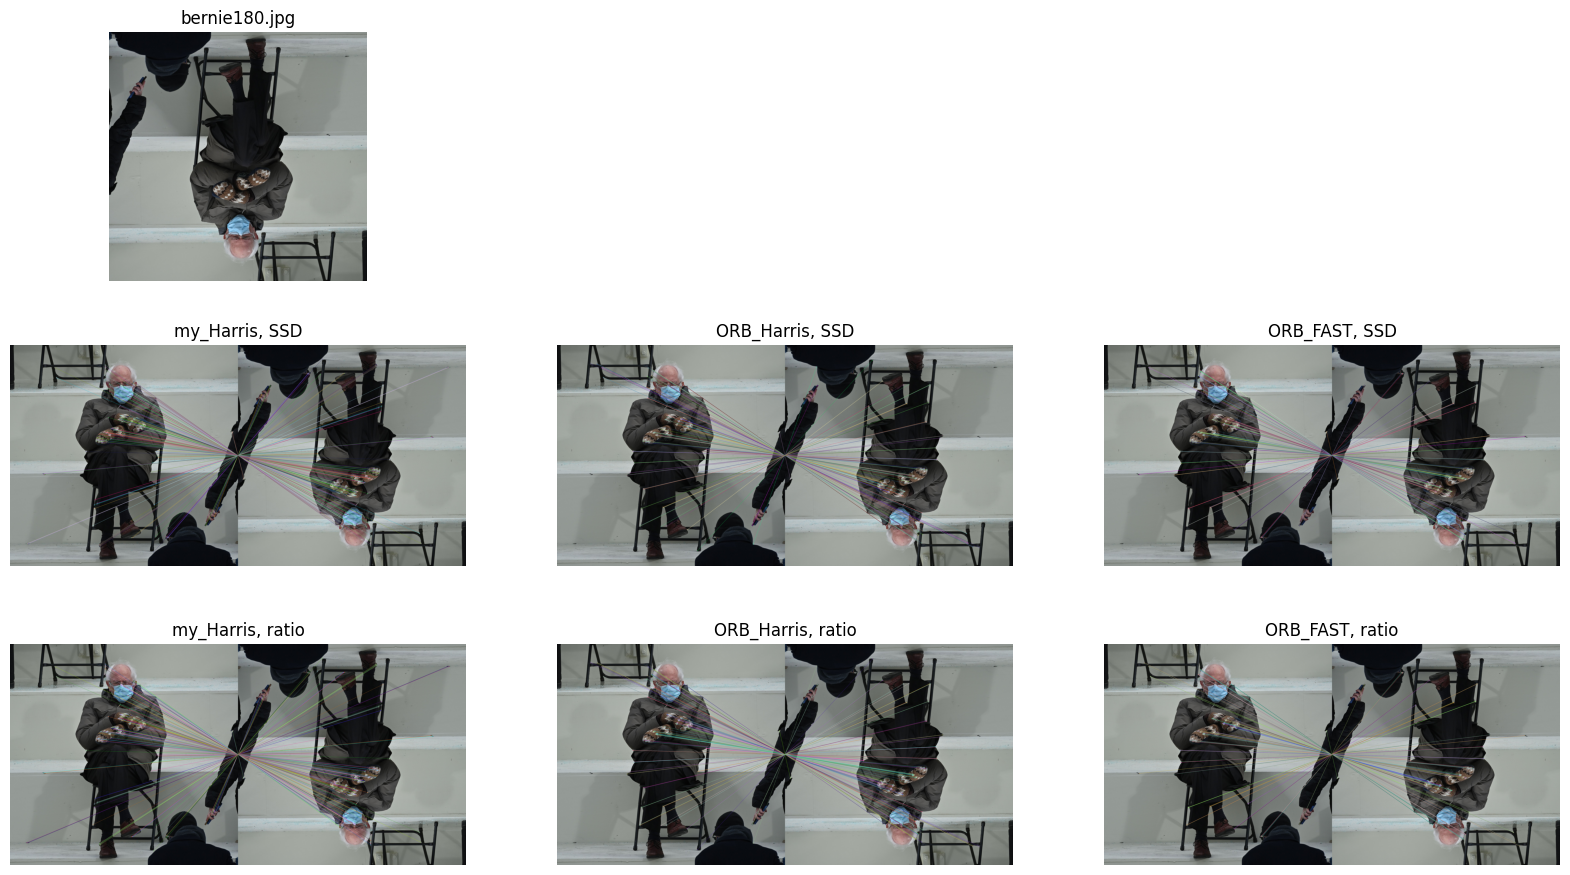

In [28]:
test_dict = {
    'color': ['bernie180.jpg', 'bernieBenefitBeautySalon.jpeg', 'BernieFriends.png', 'bernieShoolLunch.jpeg'],
    'gray': ['bernieNoisy2.png', 'berniePixelated2.png', 'brighterBernie.jpg', 'darkerBernie.jpg'],
    'blurred': ['bernieMoreblurred.jpg']
}

flat_list = test_dict['color'] + test_dict['gray'] + test_dict['blurred']

def visualise_matches(img_name, figsize_tuple):
    if img_name in test_dict['color']:
        ori = get_color(img_name)
        blur = get_blurred_grayscale(img_name)

    elif img_name in test_dict['gray']:
        ori = get_grayscale(img_name)
        blur = get_blurred_grayscale(img_name)

    else:
        ori = get_grayscale(img_name)
        blur = ori.copy().astype(np.float64)

    mH_kps, target_mH = get_kps_des(blur, method='my_harris', my_harris_kps=HarrisPointsDetector(blur, choose_threshold(blur), size))
    oH_kps, target_oH = get_kps_des(blur, method='orb_harris')
    oF_kps, target_oF = get_kps_des(blur, method='orb_fast')

    matches_mH_ssd, matches_mH_ratio = get_matches(my_harris_des, target_mH, method='ssd'), get_matches(my_harris_des, target_mH, method='ratio')
    matches_oH_ssd, matches_oH_ratio = get_matches(orb_harris_des, target_oH, method='ssd'), get_matches(orb_harris_des, target_oH, method='ratio')
    matches_oF_ssd, matches_oF_ratio = get_matches(orb_fast_des, target_oF, method='ssd'), get_matches(orb_fast_des, target_oF, method='ratio')

    plt.figure(figsize=figsize_tuple)

    plt.subplot(3, 3, 1), plt.axis('off'), plt.title(img_name)
    if img_name in test_dict['color']:
        plt.imshow(ori)
    else:
        plt.imshow(ori, cmap='gray')

    plt.subplot(3, 3, 4), plt.axis('off'), plt.title('my_Harris, SSD')
    plt.imshow(cv2.drawMatches(img_ori, my_harris_kps, ori, mH_kps, matches_mH_ssd, None))
    plt.subplot(3, 3, 7), plt.axis('off'), plt.title('my_Harris, ratio')
    plt.imshow(cv2.drawMatches(img_ori, my_harris_kps, ori, mH_kps, matches_mH_ratio, None))

    plt.subplot(3, 3, 5), plt.axis('off'), plt.title('ORB_Harris, SSD')
    plt.imshow(cv2.drawMatches(img_ori, orb_harris_kps, ori, oH_kps, matches_oH_ssd, None))
    plt.subplot(3, 3, 8), plt.axis('off'), plt.title('ORB_Harris, ratio')
    plt.imshow(cv2.drawMatches(img_ori, orb_harris_kps, ori, oH_kps, matches_oH_ratio, None))

    plt.subplot(3, 3, 6), plt.axis('off'), plt.title('ORB_FAST, SSD')
    plt.imshow(cv2.drawMatches(img_ori, orb_fast_kps, ori, oF_kps, matches_oF_ssd, None))
    plt.subplot(3, 3, 9), plt.axis('off'), plt.title('ORB_FAST, ratio')
    plt.imshow(cv2.drawMatches(img_ori, orb_fast_kps, ori, oF_kps, matches_oF_ratio, None))

    plt.show()











visualise_matches(flat_list[0], (20, 11))

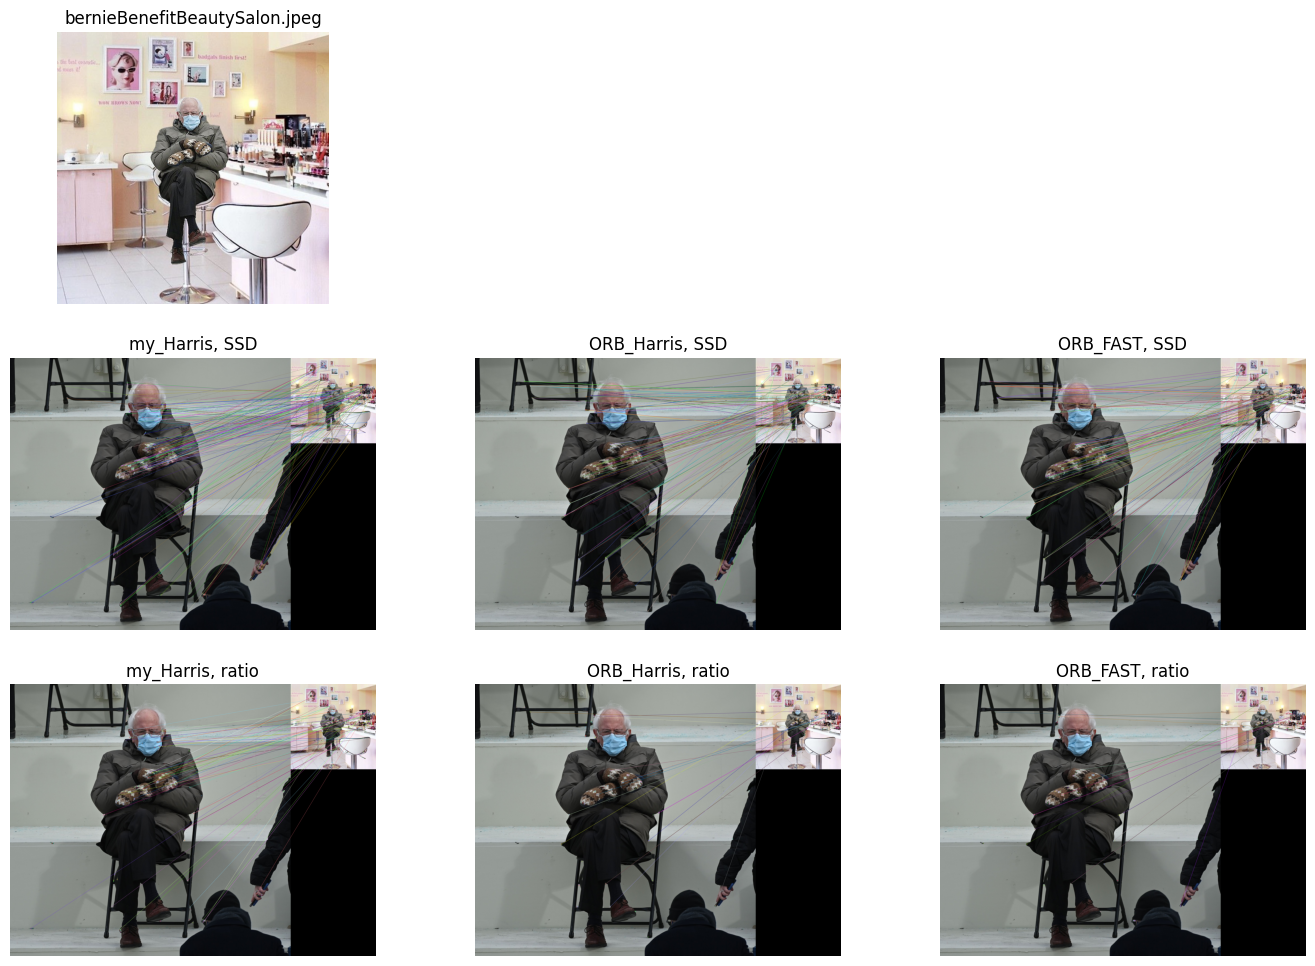

In [29]:
visualise_matches(flat_list[1], (17, 12))

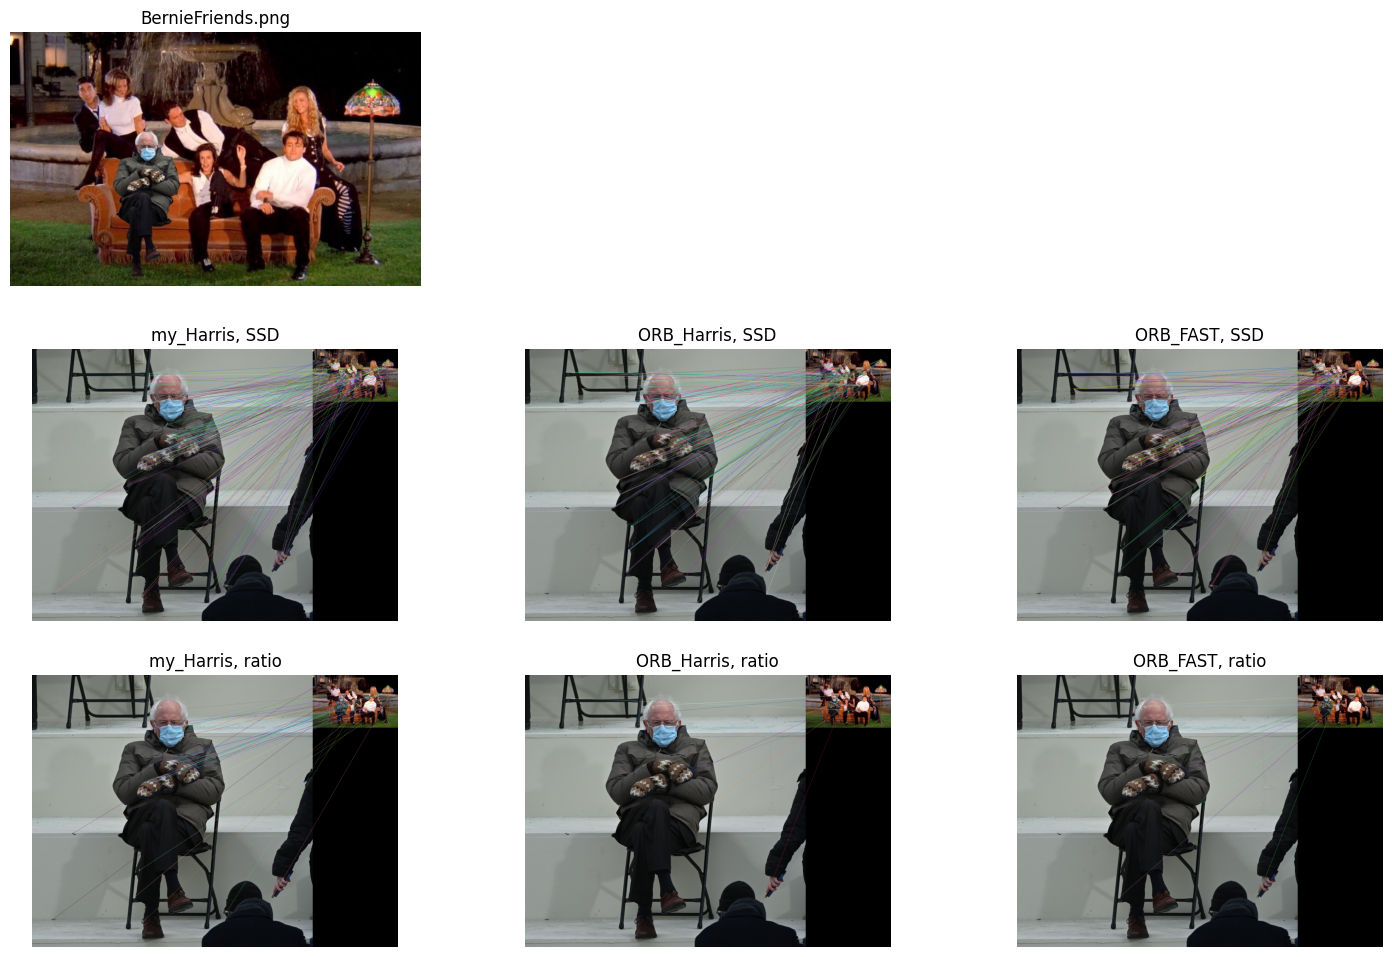

In [30]:
visualise_matches(flat_list[2], (18, 12))

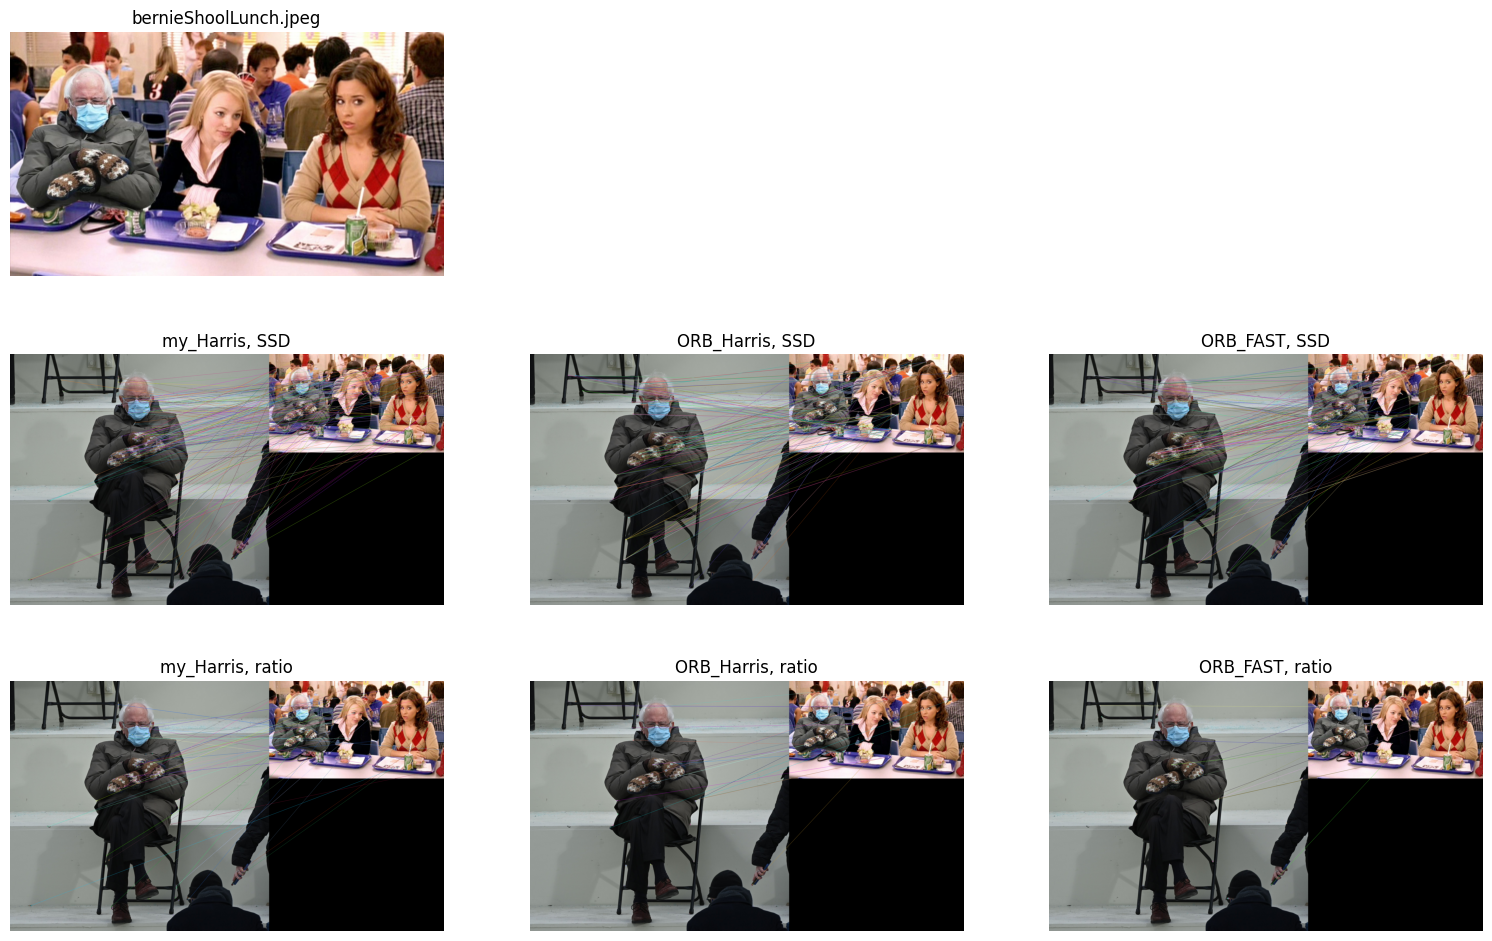

In [31]:
visualise_matches(flat_list[3], (19, 12))

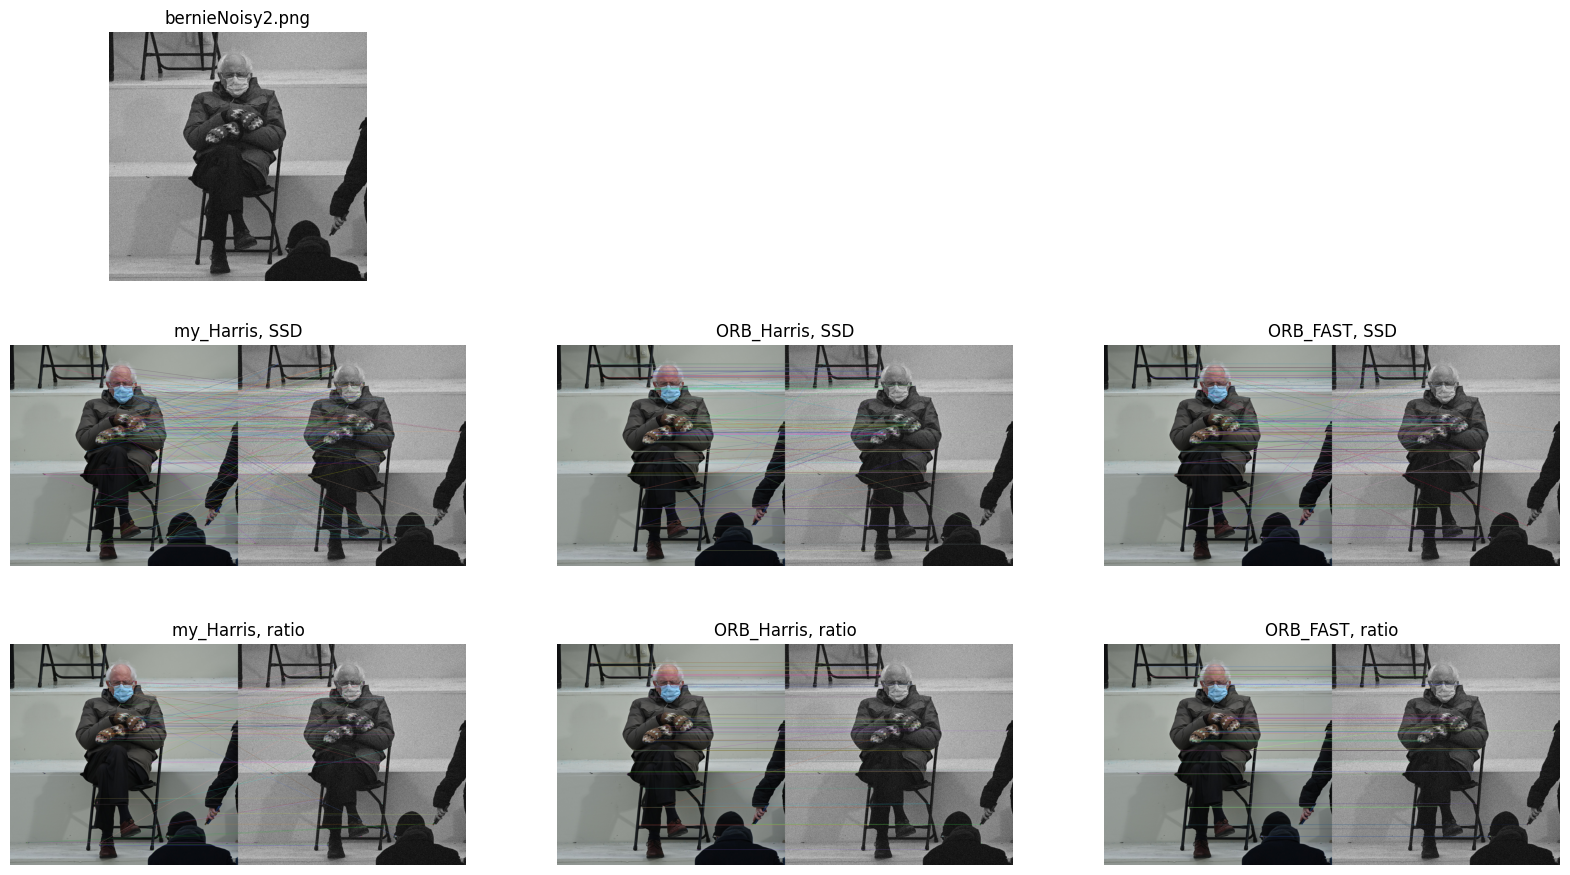

In [32]:
visualise_matches(flat_list[4], (20, 11))

\\

\\

\\

\\

\\

\\

\\

\\

\\

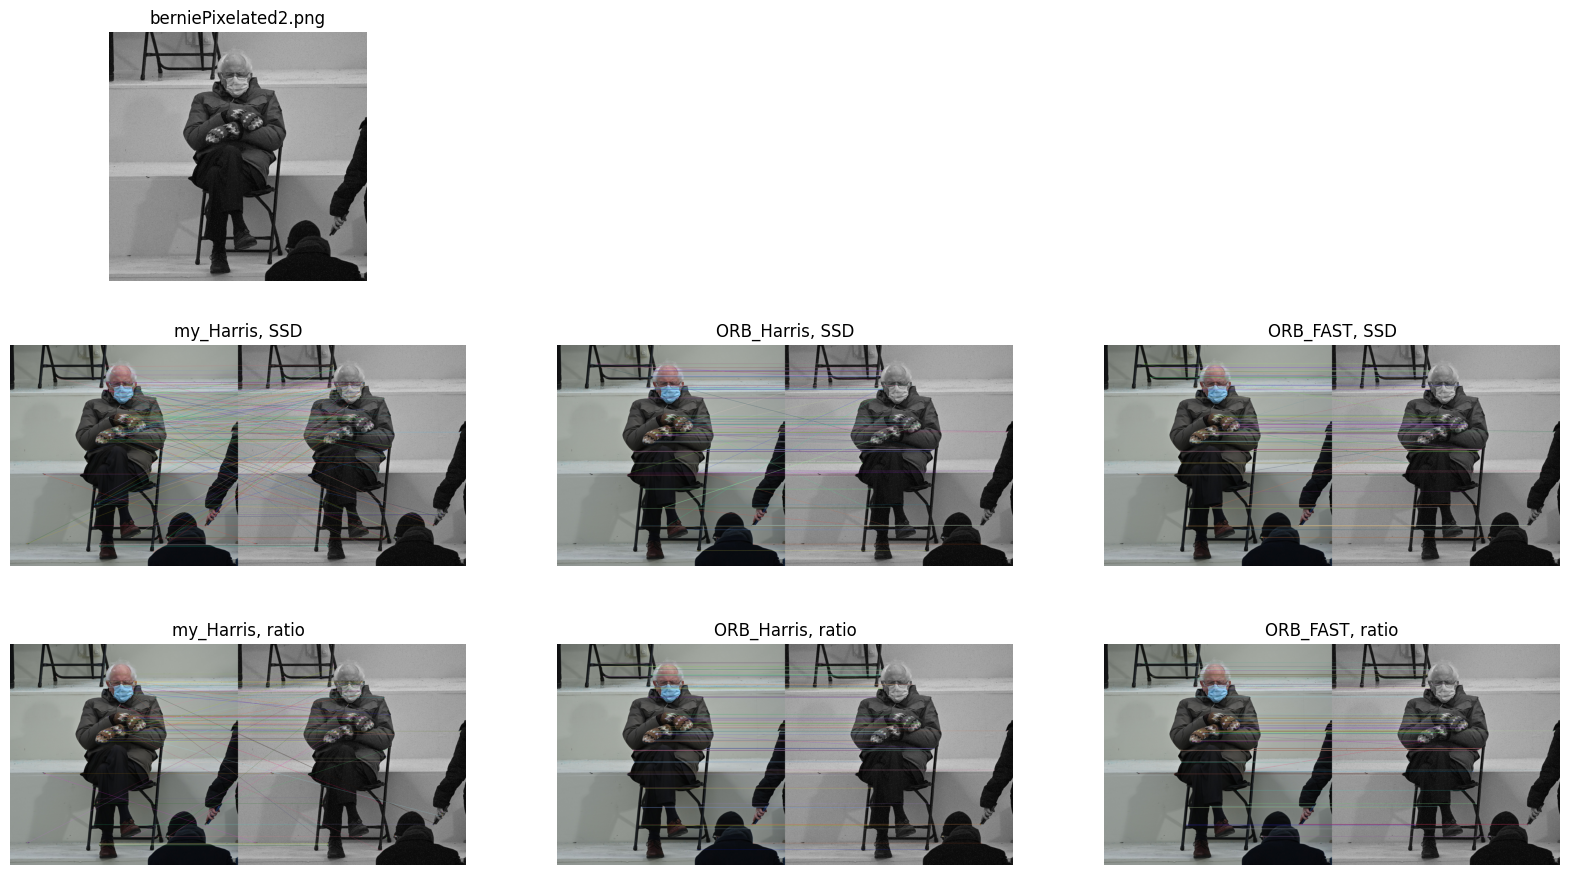

In [33]:
visualise_matches(flat_list[5], (20, 11))

\\

\\

\\

\\

\\

\\

\\

\\

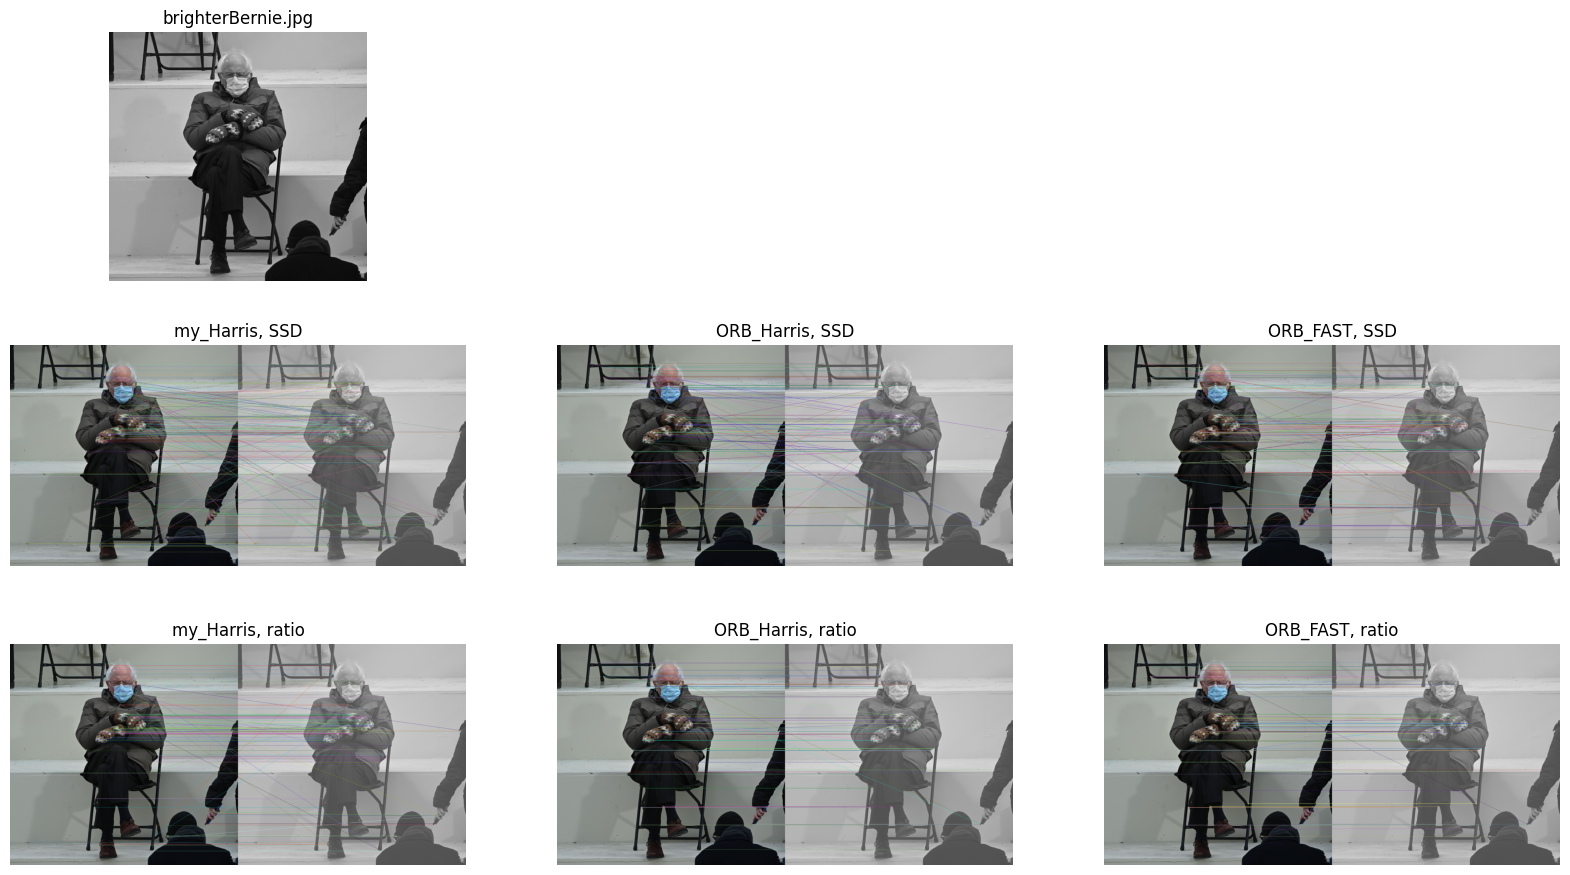

In [34]:



visualise_matches(flat_list[6], (20, 11))

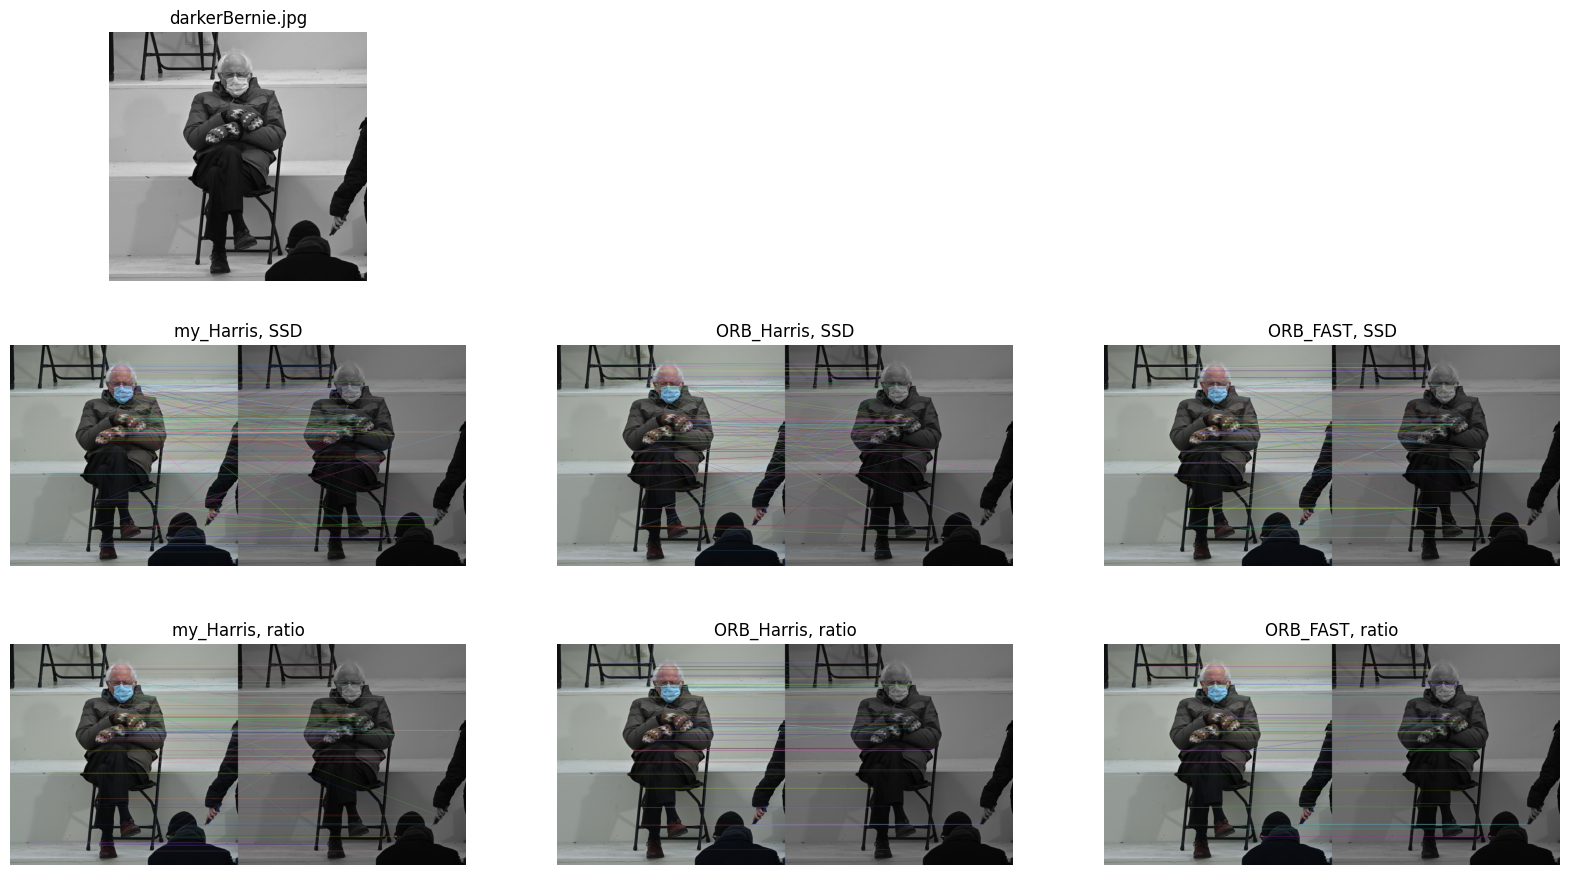

In [35]:
visualise_matches(flat_list[7], (20, 11))

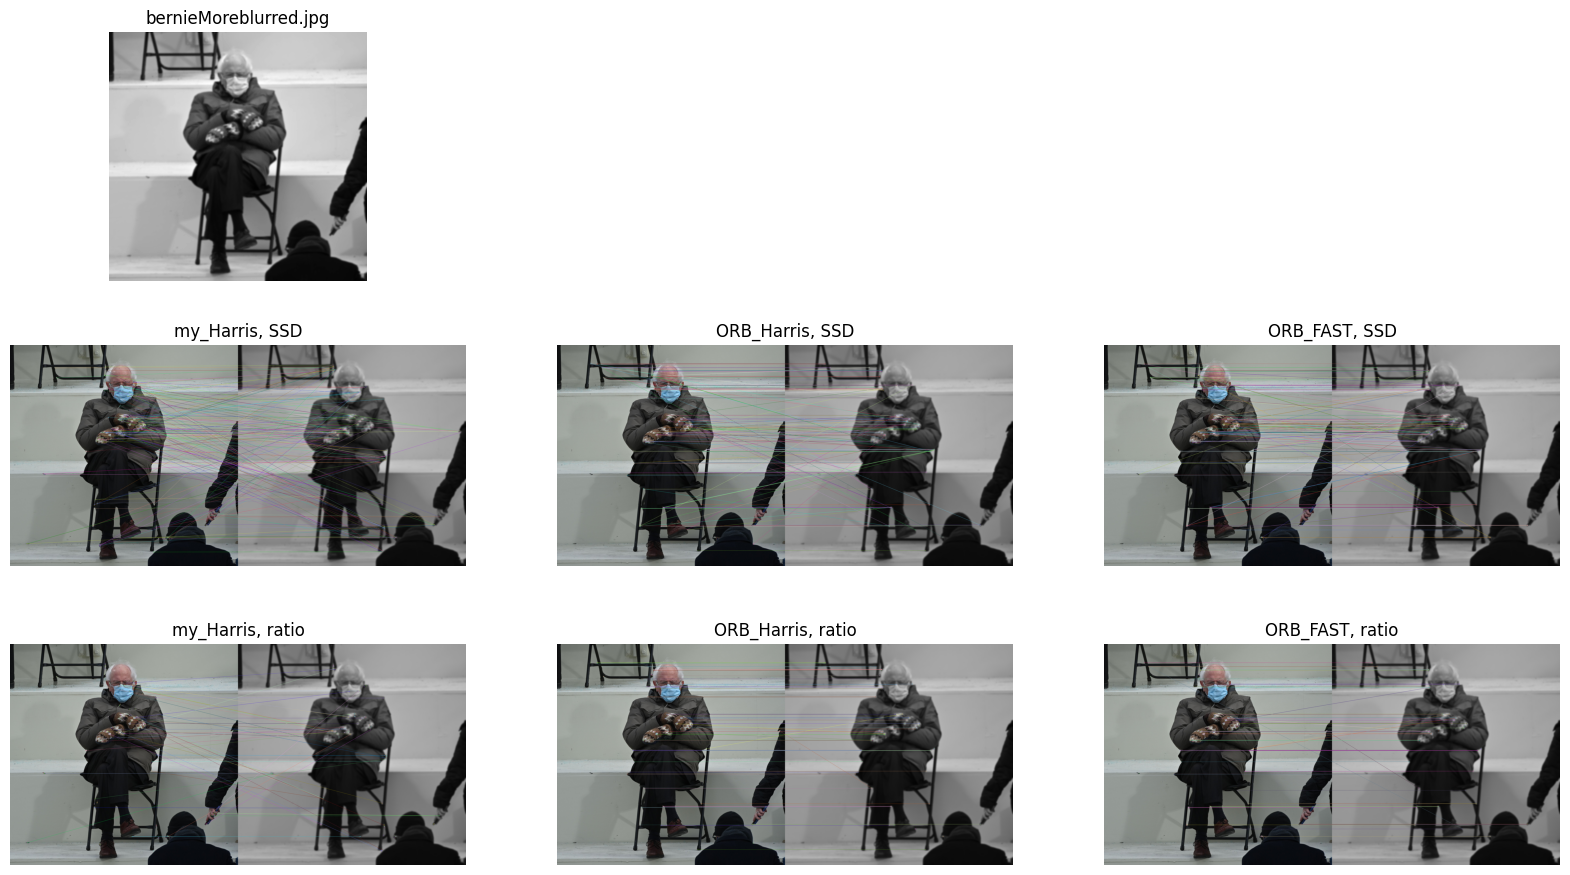

In [36]:
visualise_matches(flat_list[8], (20, 11))

\\

\\

\\

\\

\\

\\

\\

\\

\\

\\

\\

\\
**4.3 Results and observations**

*   For *bernie180.jpg*, both detectors and selection metrics produced good mathches, showing a property of rotation invariance.

*   For images in which Bernie has different sizes, both detectors had some mismatches, especially my Harris detector. This is predictable since the size of all keypoints found by my Harris detector has a hard-coded value, while ORB.Harris and ORB.FAST have various sizes for different keypoints, offering ability for handling scale changes to some extent.

*   SSD-based ratio metric produced better results than simple SSD metric in all images by discarding ambiguous matches whose best and 2nd best matches in the target image are not different enough (excluded by **ratio threshold, here 0.65**). This worked especially well for
removing mismatches on similar patterns in Bernie's gloves and similar corners of chairs.

*   Based on visualisations, ORB.Harris with ratio metric did a better job.


\\